## House Prices: Advanced Regression Techniques

1. Загрузим исходные данные.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Загрузим исходный датасет и проанализируем данные:

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
test_id = test['Id']

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Изменим тип нектрых переменных:

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Рассмотрим целевую переменную SalePrice:

D:\Netology\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


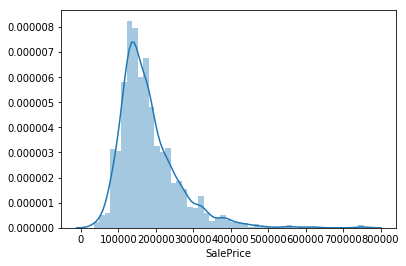

In [5]:
sns.distplot(train['SalePrice'])

Распредление имеет тяжелый хвост, посмотрим есть ли выбросы:

In [7]:
mean_salePrice=  train['SalePrice'].mean()
q25SalePrice = np.quantile(train['SalePrice'], 0.25, axis=0)
q75SalePrice = np.quantile(train['SalePrice'], 0.75, axis=0)
IQR = q75SalePrice-q25SalePrice
train['SalePrice_isoutliers']=train.apply(lambda row: True if (row.SalePrice < mean_salePrice-1.5*IQR  or row.SalePrice>mean_salePrice+1.5*IQR)  else False,axis=1)

In [8]:
train[['SalePrice_isoutliers','SalePrice']][train['SalePrice_isoutliers']==True].shape

(114, 2)

114 выбросов, пока их удалять не будем

Посмотрим взаимосвязь SalePrice и GrLivArea (согласно документации по данным там могут быть выбросы):

D:\Netology\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


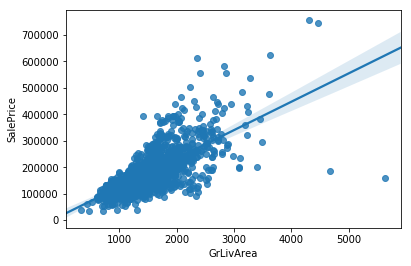

In [9]:
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True)
plt.show()

Здесь явно есть две точки, которые желательно удалить. Они явно будут ухудшать обучение.

In [10]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [12]:
train.shape

(1458, 82)

Вернемся к целевой перемнной, она распределена не нормально, сделаем логнормальное преобразование:

In [13]:
train["SalePrice"] = np.log1p(train["SalePrice"])

D:\Netology\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


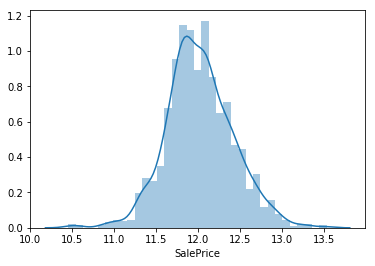

In [14]:
sns.distplot(train['SalePrice'])

Стало лучше!

Запишем нашу целевую переменную в y_train:

In [15]:
y_train_ = train['SalePrice']

Объединим наши наборы tran и test для препроцессинга:

In [16]:
train['is_test'] = 0
test['is_test']=1

In [17]:
print(train.shape,test.shape)

(1458, 83) (1459, 81)


In [18]:
train.columns ^ test.columns

Index(['SalePrice', 'SalePrice_isoutliers'], dtype='object')

Удалим целевую переменную и созданную из трейна:

In [19]:
train.drop(['SalePrice', 'SalePrice_isoutliers'],axis=1,inplace=True)

In [20]:
df_full = pd.concat([train, test])

In [21]:
print(df_full.shape,train.shape,test.shape)

(2917, 81) (1458, 81) (1459, 81)


Теперь заполним пропущенные значения:

Рассмотрим переменные и отобразим процент непропущенных значений:

In [22]:
total = df_full.isnull().sum().sort_values(ascending=False)
percent = df_full.isnull().sum()/df_full.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Percent']>0].sort_values(by=['Percent'],ascending=False)

D:\Netology\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


Посмотрим на матрицу корреляции, возможно какие-то фичи можно будет удалить:

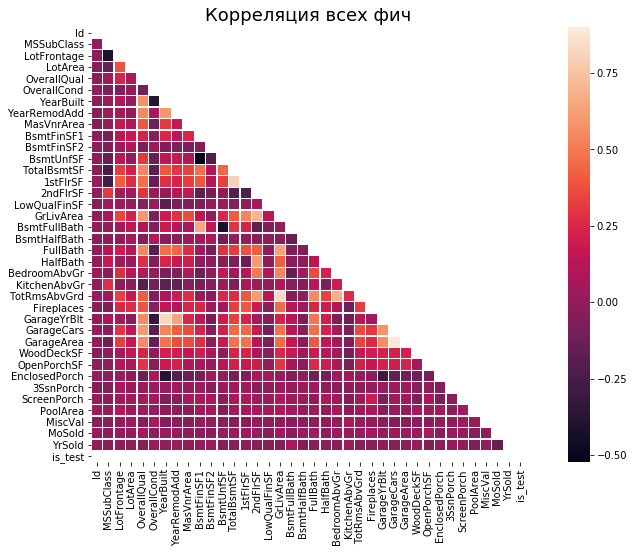

In [23]:
corrmat = train.corr()
plt.subplots(figsize=(15,8))
plt.title('Корреляция всех фич', fontsize=18)
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrmat, vmax=0.9, square=True,mask=mask, linewidths=0.2)

Сильная корреляция между переменными связанными с гаражом, также много коррелирует с общей оценкой качетва дома (Overallqual)

Часть переменных заполним как None,часть нулевым значением

In [24]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    df_full[col] = df_full[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    df_full[col] = df_full[col].fillna(0)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    df_full[col] = df_full[col].fillna(df_full[col].mode()[0])
df_full["LotFrontage"] = df_full.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [25]:
df_full.isna().sum().sort_values(ascending=False).head(5)

is_test        0
Heating        0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

Пропущенных знаений больше не осталось

In [26]:
df_full.drop(['Id'],axis=1,inplace=True)

In [27]:
for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold'):
    df_full[col] = df_full[col].astype(str)
df_full['TotalSF'] = df_full['TotalBsmtSF'] + df_full['1stFlrSF'] + df_full['2ndFlrSF']

In [28]:
df_full.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

In [29]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_full[c].values)) 
    df_full[c] = lbl.transform(list(df_full[c].values))

In [30]:
df_full = pd.get_dummies(df_full)

Разделим датасеты и удалим созданные фичи:

In [31]:
x_train = df_full[df_full['is_test']!=1]
x_test=df_full[df_full['is_test']==1]

In [32]:
x_train.drop('is_test',inplace=True,axis=1)

D:\Netology\Anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
x_test.drop('is_test',inplace=True,axis=1)

D:\Netology\Anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Разделим обучающий набор на обучающий и валидационный.

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train_, test_size=0.2, random_state=1)

In [36]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [37]:
n_folds = 10
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train,y_train)

D:\Netology\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
y_pred_clf_rf = clf_rf.predict(X_val)

In [39]:
mean_squared_log_error(y_val, y_pred_clf_rf)

0.00012502675234511495

In [40]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf_rf, X_val, y_val,cv=n_folds,scoring='r2')

array([0.80016158, 0.79088187, 0.89329299, 0.70322931, 0.78300174,
       0.86489046, 0.86708393, 0.75731501, 0.85037343, 0.77453155])

Выглядит неплохо.

Выведем важность признаков:

In [42]:
sorted(zip(map(lambda x: round(x, 4), clf_rf.feature_importances_), X_train.columns), 
             reverse=True)

[(0.4707, 'OverallQual'),
 (0.3192, 'TotalSF'),
 (0.0182, 'CentralAir'),
 (0.0123, 'GrLivArea'),
 (0.0112, 'GarageArea'),
 (0.0108, 'GarageCars'),
 (0.0105, 'YearBuilt'),
 (0.0105, 'LotArea'),
 (0.0099, 'BsmtFinSF1'),
 (0.0097, 'YearRemodAdd'),
 (0.0096, 'BsmtUnfSF'),
 (0.009, 'OverallCond'),
 (0.0057, 'GarageYrBlt'),
 (0.0052, 'Fireplaces'),
 (0.0039, 'GarageType_Detchd'),
 (0.0037, 'MSZoning_RM'),
 (0.0034, 'MoSold'),
 (0.0033, 'LotFrontage'),
 (0.0032, 'WoodDeckSF'),
 (0.0031, 'BsmtFinType1'),
 (0.003, 'BsmtExposure'),
 (0.0029, 'OpenPorchSF'),
 (0.0025, 'EnclosedPorch'),
 (0.0024, 'MasVnrArea'),
 (0.0023, 'TotRmsAbvGrd'),
 (0.0022, 'SaleCondition_Normal'),
 (0.002, 'BsmtQual'),
 (0.0019, 'GarageFinish'),
 (0.0018, 'FullBath'),
 (0.0017, 'YrSold'),
 (0.0017, 'KitchenQual'),
 (0.0017, 'BedroomAbvGr'),
 (0.0016, 'Functional'),
 (0.0015, 'MSSubClass'),
 (0.0015, 'GarageCond'),
 (0.0015, 'Exterior1st_BrkComm'),
 (0.0012, 'SaleCondition_Abnorml'),
 (0.0012, 'Neighborhood_NAmes'),
 (0.001

Сделаем сабмит на kaggle

In [43]:
y_pred_test_clf_rf = clf_rf.predict(x_test)

In [44]:
df_Kaggle = pd.concat([test_id,pd.Series(np.expm1(y_pred_test_clf_rf))],axis=1)

In [45]:
df_Kaggle.columns= ['Id','SalePrice']
df_Kaggle.set_index('Id');

In [46]:
df_Kaggle.to_csv('Kaggle_1.csv',index=False)

<img src="Kaggle1.PNG">

Самые значимые признаки 'OverallQual', 'TotalSF','CentralAir', 'GrLivArea'  - что в целом логично

В целом качество модели уже неплохое, попробуем улучшить с помощью стекинга

## Стекинг

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [192]:
models = [RandomForestRegressor(), Ridge(),SVR(kernel='poly')]

Т.к. мы будем использовать модели, чувствительные к разным числовым переменным, сделаем масштабирование:

In [193]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
X_train_scaled = pd.DataFrame(scaler.transform(x_train),columns=x_train.columns)
scaler.fit(x_test)
X_test_scaled = pd.DataFrame(scaler.transform(x_test),columns=x_test.columns)

D:\Netology\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Netology\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
D:\Netology\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Netology\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [194]:
X_train, X_test, y_train, y_val = train_test_split(X_train_scaled, y_train_, test_size=0.2, random_state=42)

In [195]:
def get_X_train_meta(models, X_train, y_train):
    X_train_meta = np.empty((y_train.shape[0], len(models)))
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    for train_id, test_id in kf.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_id,:], X_train.iloc[test_id,:]
        y_train_cv, y_test_cv = y_train.iloc[train_id], y_train.iloc[test_id]
        for i, model in enumerate(models):
            model.fit(X_train_cv, y_train_cv)            
            X_train_meta[test_id, i] = model.predict(X_test_cv)
    return pd.DataFrame(X_train_meta,columns=["RandomForestRegressor", "Ridge","SVR"])

In [196]:
meta_X_train=get_X_train_meta(models,X_train,y_train)

D:\Netology\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Netology\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account

In [197]:
meta_alg = LinearRegression()
meta_alg.fit(meta_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

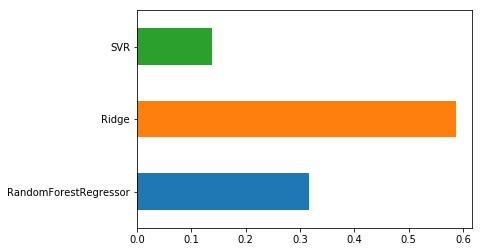

In [201]:
pd.Series(meta_alg.coef_.flatten(), index=["RandomForestRegressor", "Ridge","SVR"]).plot(kind='barh')

In [228]:
meta_X_test = []
for model in models:
    y_1 = model.predict(X_test_scaled)
    meta_X_test.append(y_1)


In [229]:
meta_X_test= pd.DataFrame(np.array(meta_X_test).T,columns=["RandomForestRegressor", "Ridge","SVR"])

In [232]:
df_Kaggle = pd.concat([test_id,pd.Series(np.expm1(meta_alg.predict(meta_X_test)))],axis=1)
df_Kaggle.columns= ['Id','SalePrice']
df_Kaggle.set_index('Id');
df_Kaggle.to_csv('Kaggle_Ensemble.csv',index=False)

С помощью ансамблирования, нам значительно удалось улучшить наши результаты:

<img src="Kaggle_ensemble.PNG">